In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [238]:
def load(file):
    lines = open(file, "r").readlines()

    for i, line in enumerate(lines):
        # Find root
        if line.startswith('; |'):
            root_line = i
        if line.startswith('Note: For table entries with two numbers listed,'):
            last_line = i - 2

    del lines[last_line+1:]

    # Extract header:
    header = list(filter(None,[x.strip() for x in lines[root_line - 2].split(';')]))

    # Extract data:
    del lines[0:root_line]

    raw_data = []

    for line in lines:
        row = list(filter(None, [x.strip() for x in line.split(';')]))
        # The utilization number between () is resource utilization in the unit itself, without its children.
        # Remove utilization of entity itself:
        row = [x.split('(')[0] for x in row]
        raw_data.append(row)

    df = pd.DataFrame(data=raw_data, columns=header)
    
    df['ALMs'] = pd.to_numeric(df['ALMs needed [=A-B+C]'])
    df['Regs'] = pd.to_numeric(df['Dedicated Logic Registers'])
    df['M20Ks'] = pd.to_numeric(df['M20Ks'])
    df['DSP'] = pd.to_numeric(df['DSP Blocks'])
    
    return df[['Entity Name', 'Full Hierarchy Name', 'ALMs', 'Regs', 'M20Ks', 'DSP']]

In [239]:
device = {
    'Device' : 'Arria 10 GX 1150',
    'LE' : 1150 * 1e3,
    'ALM' : 427200,
    'Register' : 1708800,
    'Memory M20k' : 54260,
    'Memory MLAB' : 12984,
    'Variable-precision DSP Block': 1518,
    '18x19 Multiplier' : 3036,
}

reports = [
    (1, '/home/johan/Desktop/jsonpaper/builds/battery/1/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (2, '/home/johan/Desktop/jsonpaper/builds/battery/2/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (4, '/home/johan/Desktop/jsonpaper/builds/battery/4/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (8, '/home/johan/Desktop/jsonpaper/builds/battery/8/synth/afu_default-Resource-Utilization-by-Entity.rpt'),
    (16, '/home/johan/Desktop/jsonpaper/builds/battery/16/synth/afu_default-Resource-Utilization-by-Entity.rpt')
]

# entities of interest
eoi = ['dcp_top', 'OpaeAxiTop', 'battery_status', 'BattSchemaParser', 'ArrayReader', 'ArrayWriter']
#df = df[df['Entity Name'].isin(eoi)]

records = []
for report in reports:
    # Load file
    df = load(report[1])
    # Set number of kernels
    df['Kernels'] = report[0]
    #records.append(df.loc['|'])
    records.append(df[df['Entity Name'].isin(eoi)])
    

df = pd.concat(records)

df = df.groupby(['Kernels', 'Entity Name']).aggregate('sum')

df['ALMs %'] = df.ALMs / device['ALM'] * 100
df['Regs %'] = df.Regs / device['Register']  * 100
df['M20Ks %'] = df.M20Ks / device['Memory M20k']  * 100
df['DSP %'] = df.DSP / device['18x19 Multiplier']   * 100

display(df)

ALMs    Regs  M20Ks  DSP     ALMs %     Regs %  \
Kernels Entity Name                                                            
1       ArrayReader         4331.8    8145     26    0   1.013998   0.476650   
        ArrayWriter         8170.0   22260     54    0   1.912453   1.302669   
        BattSchemaParser    2683.4    1204      0    0   0.628137   0.070459   
        OpaeAxiTop         17772.8   38318     84    0   4.160300   2.242392   
        battery_status      2815.9    1500      0    0   0.659153   0.087781   
        dcp_top            55202.5   91086    250    0  12.921934   5.330407   
2       ArrayReader         8702.3   16321     52    0   2.037055   0.955115   
        ArrayWriter        15769.3   44537    108    0   3.691316   2.606332   
        BattSchemaParser    5510.6    2475      0    0   1.289934   0.144838   
        OpaeAxiTop         34085.8   73034    164    0   7.978886   4.273993   
        battery_status      5775.1    3050      0    0   1.351849   0.178488   
        dcp_top            71071.6  125776    330    0  16.636610   7.360487   
4       ArrayReader        17234.7   32583    104    0   4.034340   1.906777   
        ArrayWriter        31136.6   89104    216    0   7.288530   5.214419   
        BattSchemaParser   10931.8    4886      0    0   2.558942   0.285932   
        OpaeAxiTop         66138.3  142186    324    0  15.481812   8.320810   
        battery_status     11451.5    6025      0    0   2.680595   0.352587   
        dcp_top           103160.8  194915    490    0  24.148127  11.406543   
8       ArrayReader        34207.9   65134    208    0   8.007467   3.811681   
        ArrayWriter        61527.4  178099    432    0  14.402481  10.422460   
        BattSchemaParser   21891.6    9683      0    0   5.124438   0.566655   
        OpaeAxiTop        130417.5  280318    644    0  30.528441  16.404377   
        battery_status     22923.9   11909      0    0   5.366081   0.696922   
        dcp_top           167358.8  333046    810    0  39.175749  19.490051   
16      ArrayReader        67681.6  130233    416    0  15.843071   7.621313   
        ArrayWriter       123513.5  356113    864    0  28.912336  20.839946   
        BattSchemaParser   43639.2   19232      0    0  10.215169   1.125468   
        OpaeAxiTop        258435.3  556644   1284    0  60.495154  32.575140   
        battery_status     45631.7   23714      0    0  10.681578   1.387757   
        dcp_top           295067.3  609356   1450    0  69.070061  35.659878   

                           M20Ks %  DSP %  
Kernels Entity Name                        
1       ArrayReader       0.047917    0.0  
        ArrayWriter       0.099521    0.0  
        BattSchemaParser  0.000000    0.0  
        OpaeAxiTop        0.154810    0.0  
        battery_status    0.000000    0.0  
        dcp_top           0.460745    0.0  
2       ArrayReader       0.095835    0.0  
        ArrayWriter       0.199042    0.0  
        BattSchemaParser  0.000000    0.0  
        OpaeAxiTop        0.302248    0.0  
        battery_status    0.000000    0.0  
        dcp_top           0.608183    0.0  
4       ArrayReader       0.191670    0.0  
        ArrayWriter       0.398083    0.0  
        BattSchemaParser  0.000000    0.0  
        OpaeAxiTop        0.597125    0.0  
        battery_status    0.000000    0.0  
        dcp_top           0.903059    0.0  
8       ArrayReader       0.383339    0.0  
        ArrayWriter       0.796167    0.0  
        BattSchemaParser  0.000000    0.0  
        OpaeAxiTop        1.186878    0.0  
        battery_status    0.000000    0.0  
        dcp_top           1.492812    0.0  
16      ArrayReader       0.766679    0.0  
        ArrayWriter       1.592333    0.0  
        BattSchemaParser  0.000000    0.0  
        OpaeAxiTop        2.366384    0.0  
        battery_status    0.000000    0.0  
        dcp_top           2.672318    0.0

Index(['ArrayReader', 'ArrayWriter', 'BattSchemaParser', 'OpaeAxiTop',
       'battery_status', 'dcp_top'],
      dtype='object', name='Entity Name')

Int64Index([1, 2, 4, 8, 16], dtype='int64', name='Kernels')

['ALMs %', 'Regs %', 'M20Ks %']

[(0.11379369138959927, 0.2300085251491899, 0.44306905370843996),
 (0.19575099942889762, 0.5323053493241956, 0.1751456310679611),
 (0.5881182323675741, 0.15070529704419078, 0.15070529704419078),
 (0.6132848190822722, 0.5083808368708307, 0.1694602789569435),
 (0.7637589670014348, 0.20722142515542796, 0.5979818268770923),
 (0.03843137254901963, 0.026627450980392167, 0.016470588235294126)]

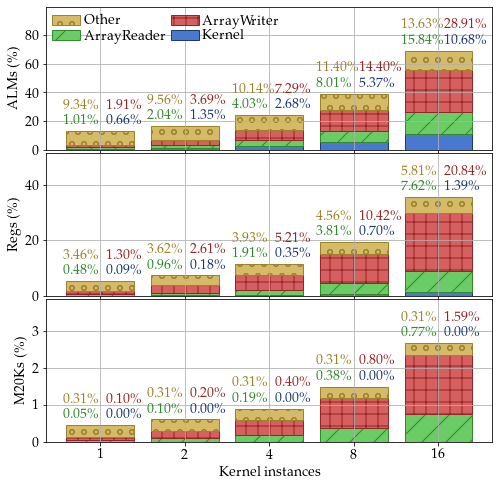

In [473]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

ents = doi.index.unique(1)
kers = doi.index.unique(0)
ress = ['ALMs %', 'Regs %', 'M20Ks %'] #, 'DSP %'] , designs dont use dsp

display(ents)
display(kers)
display(ress)

fig, ax = plt.subplots(nrows=len(ress), ncols=1, figsize=[8, 8])

hatches = [None, '/', '+', 'o']
colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
dcolors = [lighten_color(x, 1.6) for x in colors]
display(dcolors)

doi = df[cols]

ymaxes = [doi[x].max()*1.2 for x in ress]

ax[len(ress)-1].set_xlabel('Kernel instances')

w=0.8
ap = {'arrowstyle' : '->'}
lf = '{:2.2f}\%'
ls = '-'
lw = 1

for r,res in enumerate(ress):
    yl = ress[r].replace('%', '(\%)')
    ax[r].set_ylabel(yl)
        
    for c, knl in enumerate(kers):
        ax[r].set_ylim(0, min(100,1.2*ymaxes[r]))
        ax[r].set_xticks(range(0, len(kers)))
        ax[r].set_xticklabels(kers)
        ax[r].grid(which='both')
        
        ab = doi.loc[knl,'battery_status'][res]
        ar = doi.loc[knl,'ArrayReader'][res]
        aw = doi.loc[knl,'ArrayWriter'][res]
        ao = doi.loc[knl,'dcp_top'][res] - ar - aw - ab
        
        bottoms = [0, ab, ab+ar, ab+ar+aw, ab+ar+aw+ao]
        
        bb = ax[r].bar(x=c, height=ab, width=w, bottom=bottoms[0], color=colors[0], ec=dcolors[0], hatch=hatches[0], ls=ls, lw=lw)
        br = ax[r].bar(x=c, height=ar, width=w, bottom=bottoms[1], color=colors[1], ec=dcolors[1], hatch=hatches[1], ls=ls, lw=lw)
        bw = ax[r].bar(x=c, height=aw, width=w, bottom=bottoms[2], color=colors[2], ec=dcolors[2], hatch=hatches[2], ls=ls, lw=lw)
        bo = ax[r].bar(x=c, height=ao, width=w, bottom=bottoms[3], color=colors[3], ec=dcolors[3], hatch=hatches[3], ls=ls, lw=lw)
        
        ax[r].annotate(text=lf.format(ab), xy=(c+w/12, bottoms[4]+0.05*ymaxes[r]), color=dcolors[0])
        ax[r].annotate(text=lf.format(ar), xy=(c-w/1.8, bottoms[4]+0.05*ymaxes[r]), color=dcolors[1])
        ax[r].annotate(text=lf.format(aw), xy=(c+w/12, bottoms[4]+0.18*ymaxes[r]), color=dcolors[2])
        ax[r].annotate(text=lf.format(ao), xy=(c-w/1.8, bottoms[4]+0.18*ymaxes[r]), color=dcolors[3])
        

for r, res in enumerate(ress):
    if r != len(ress)-1:
        ax[r].get_xaxis().set_ticklabels([])


fig.legend([bo, br, bw, bb],
           ['Other', 'ArrayReader', 'ArrayWriter', 'Kernel'],
           ncol=2,
           bbox_to_anchor=[0.55, 0.89],
           labelspacing=0,
           handletextpad=0.25,
           handlelength=2.0,
           columnspacing=0.5,
           frameon=False
          )
        
plt.subplots_adjust(hspace=0.025, wspace=0)

fig.savefig('utilization.pdf', bbox_inches='tight')


[]

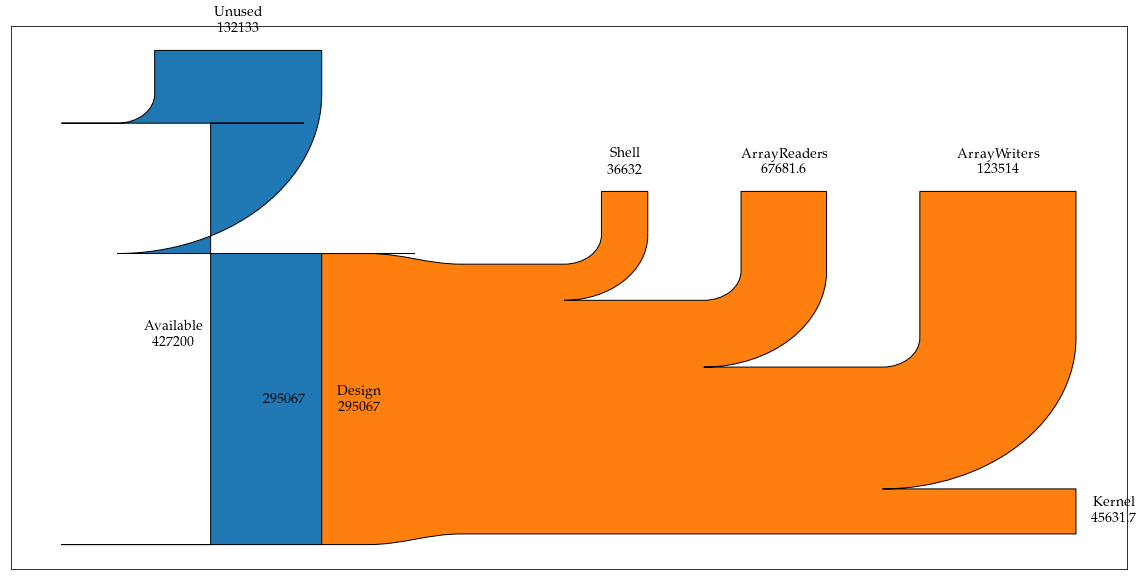

In [443]:
from matplotlib.sankey import Sankey

k = 16

fig, ax = plt.subplots(figsize=[20, 10])

flows_a = [device['ALM'],
          df.loc[k,'dcp_top']['ALMs'] - device['ALM'],
          - df.loc[k,'dcp_top']['ALMs']]
labels_a = ['Available', 'Unused', 'Design']
or_a = [0, 1, 0]

flows_b = [df.loc[k,'dcp_top']['ALMs'],
         df.loc[k,'OpaeAxiTop']['ALMs'] - df.loc[k,'dcp_top']['ALMs'],
         -df.loc[k,'ArrayReader']['ALMs'],
         -df.loc[k,'ArrayWriter']['ALMs'],
         -df.loc[k,'battery_status']['ALMs']]

labels_b = ['', 'Shell', 'ArrayReaders', 'ArrayWriters', 'Kernel']

or_b=[0, 1, 1, 1, 0]

s = Sankey(ax=ax,
           scale=1/df.loc[k,'dcp_top']['ALMs'],
           head_angle=180,
           offset=0.1,
           shoulder=0)

s.add(flows=flows_a, 
      labels=labels_a,
      trunklength=0.1,
      orientations=or_a)

s.add(flows=flows_b, 
      labels=labels_b,
      orientations=or_b,
      prior=0,
      connect=(2,0))

plt.autoscale(ax)

ax.set_yticks([])
ax.set_xticks([])